# ADICIONANDO CAMINHO PARA GOOGLE DRIVE

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
caminhoCSV = "/content/drive/My Drive/CBIC2019/CSV/features_8bits_8k.csv"

In [0]:
import numpy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from IPython.display import HTML, display

In [0]:
# ABRINDO O CSV COMO UM NUMPY ARRAY
datasetOriginal = numpy.genfromtxt(caminhoCSV, delimiter=",")

# DELETANDO A PRIMEIRA LINHA (CABECALHO) E A SEGUNDA COLUNA (NOMES DOS ARQUIVOS)
datasetOriginal = numpy.delete(datasetOriginal, 0, 0)
datasetOriginal = numpy.delete(datasetOriginal, 1, 1)

# DEFININFDO ALGUMAS FUNÇÕES

In [0]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
def kFold(dataset):

    # ESSA FUNCAO RETORNARA UMA MATRIZ COM AS SEGUINTES DIMENSOES
    # matriz[iteracaoKFold][colunaDeTreinoOuTeste][dadoPuro][feature]
    # iteracaoKFold -> vai de 0 a 9 e representa as 10 iteracoes do KFold
    # colunaDeTreinoOuTeste -> vai pegar os dados de treinamento (0) ou os de teste (1)
    # dadoPuro -> dado com varias features, a pasta e a classificacao correta
    # feature -> seleciona uma das 24 features do dado
    
    matriz = []
    
    for pastaTeste in range(1,11):

        rodada = []
        xTrain = []
        xTest  = []

        for dado in dataset:
            if int(dado[0]) == pastaTeste:
                xTest.append(dado)
            else:
                xTrain.append(dado)
        
        rodada.append(xTrain)
        rodada.append(xTest)
        
        matriz.append(rodada)
    
    return matriz

In [0]:
def rearranjarDataset(dataset, datasetOriginal, featureAtual, i):
    
    # ESSA FUNCAO ADICIONA UMA NOVA FEATURE AO DATASET
    
    # REMOVENDO A COLUNA DE CLASSIFICACAO
    dataset = dataset[:,0:-1]

    # SE NAO FOR A PRIMEIRA ITERACAO, EXCLUIR A ULTIMA FEATURE
    if(i != 0):
        dataset = dataset[:,0:-1]

    # ADICIONANDO A FEATURE ATUAL NO DATASET
    colunaNova = datasetOriginal[:,featureAtual]
    dataset = numpy.column_stack((dataset, colunaNova))

    # ADICIONANDO NOVAMENTE A CLASSIFICACAO
    colunaNova = datasetOriginal[:,23]
    dataset = numpy.column_stack((dataset, colunaNova))
    
    return dataset

In [0]:
def novaMelhorFeature(dataset, datasetOriginal, melhorFeature, featuresRestantes):
    
    # ESSA FUNCAO SERVE PARA QUE, DEPOIS DE DEFINIDA A NOVA FEATURE QUE VAI ENTRAR NO DATASET PERMANENTEMENTE, 
    # REARRANJAR O DATASET E REMOVER ESSA FEATURE DO ARRAY DE FEATURES RESTANTES
    
    # REMOVENDO A COLUNA DE CLASSIFICACAO E A ULTIMA FEATURE UTILIZADA
    dataset = dataset[:,0:-2]

    # ADICIONANDO A FEATURE NOVA NO DATASET
    colunaNova = datasetOriginal[:,melhorFeature]
    dataset = numpy.column_stack((dataset, colunaNova))

    # ADICIONANDO NOVAMENTE A CLASSIFICACAO
    colunaNova = datasetOriginal[:,23]
    dataset = numpy.column_stack((dataset, colunaNova))
    
    # REMOVENDO DO ARRAY DE FEATURES RESTANTES
    indexPraRemover = numpy.where(featuresRestantes == melhorFeature)
    featuresRestantes = numpy.delete(featuresRestantes, indexPraRemover)
        
    return dataset, featuresRestantes

# KFOLD

In [0]:
with open('/content/drive/My Drive/CBIC2019/logKFold.txt', 'w') as file:

  # O DATASET COMECA SO COM A COLUNA 0 (PASTA) E A 23 (CLASSIFICACAO)
  dataset = numpy.delete(datasetOriginal, numpy.s_[1:-1], axis=1)

  # ARRAY DE FEATURES QUE FALTAM, 0 E A PASTA E 23 E A CLASSIFICACAO, POR ISSO NAO ENTRAM
  featuresRestantes = numpy.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

  # ISSO AQUI E PRA PEGAR TODAS AS ACURACIAS DE TODAS AS ITERACOES
  todasAcuraciasKFold = []

  # ENQUANTO HOUVEREM FEATURES A SEREM TESTADAS
  while(len(featuresRestantes) != 0):

      file.write("\n\n\nNOVA ITERAÇÃO DO WHILE")
      file.write("\n\nFeatures restantes: " + str(featuresRestantes))

      melhorAcuraciaKNN = 0
      melhorFeatureKNN = 1

      # PARA CADA FEATURE RESTANTE EU A ADICIONO NAS QUE JA ESTAO SENDO UTILIZADAS
      for i, featureAtual in enumerate(featuresRestantes):

          file.write("\n\nTestando a feature " + str(featureAtual))

          # REARRANJO O DATASET COM A FEATURE ATUAL
          dataset = rearranjarDataset(dataset, datasetOriginal, featureAtual, i)

          # AGORA QUE JA TENHO UM DATASET COM AS FEATURES DA VEZ, TENHO QUE TESTAR OS CLASSIFICADORES
          knn = KNeighborsClassifier(7)
          arrayAcuraciasKNN = []

          # PARA CADA ITERACAO DO KFOLD
          matrizKFold = kFold(dataset)
          for iteracaoKFold in matrizKFold:

              # SEPARANDO OS DADOS DE TREINAMENTO E TESTE E JÁ EXCLUINDO A COLUNA 0 (pasta)
              dadosTreino = numpy.delete(iteracaoKFold[0], 0, axis=1)
              dadosTeste  = numpy.delete(iteracaoKFold[1], 0, axis=1)

              # SEPARANDO O QUE E X E Y
              xTrain = numpy.delete(dadosTreino, dadosTreino.shape[1] - 1, axis=1) # exclui a coluna do target
              xTest  = numpy.delete(dadosTeste, dadosTeste.shape[1] - 1, axis=1) # exclui a coluna do target
              yTrain = numpy.delete(dadosTreino, numpy.s_[0:dadosTreino.shape[1] - 1], axis=1).ravel() # exclui as colunas menos a 22
              yTest  = numpy.delete(dadosTeste, numpy.s_[0:dadosTeste.shape[1] - 1], axis=1).ravel() # exclui as colunas menos a 22

              # TREINANDO O CLASSIFICADOR (ignorando a pasta e usando a coluna 23 como target)
              knn = knn.fit(xTrain, yTrain)

              # PREDIZENDO
              yKNN = knn.predict(xTest)

              # VERIFICANDO A ACURACIA
              arrayAcuraciasKNN.append(accuracy_score(yTest, yKNN))

              # TAMBEM VOU COLOCAR NAS ACURACIAS GERAIS
              todasAcuraciasKFold.append(accuracy_score(yTest, yKNN))

          file.write("\nA média das acurácias no KFold é " + str(numpy.mean(arrayAcuraciasKNN)))
          file.write("\nA melhor acurácia até agora tinha sido " + str(melhorAcuraciaKNN))

          # AGORA JA TENHO TODAS AS ACURACIAS DO KFOLD, VOU TIRAR A MEDIA 
          # E VER SE COM ESSA FEATURE O RESULTADO FOI BOM
          if numpy.mean(arrayAcuraciasKNN) > melhorAcuraciaKNN:
              file.write("\nNova melhor feature identificada!")
              melhorAcuraciaKNN = numpy.mean(arrayAcuraciasKNN)
              melhorFeatureKNN = featureAtual
              file.write("\nMelhor feature: " + str(melhorFeatureKNN) + ". Melhor acurácia: " + str(melhorAcuraciaKNN))

      # DEPOIS QUE ACABAR, EU REMOVO A MELHOR FEATURE DAS FEATURES RESTANTES E COLOCO ELA FIXA NO DATASET
      file.write("\n\nTerminou o while. A melhor feature foi a " + str(melhorFeatureKNN) + ". Colocando-a fixa no dataset.")
      dataset, featuresRestantes = novaMelhorFeature(dataset, datasetOriginal, melhorFeatureKNN, featuresRestantes)

(array([ 29.,  60.,  54.,  47.,  65., 222., 323., 332., 262., 132., 122.,
        174., 177., 151., 155., 116.,  50.,  28.,  21.,  10.]),
 array([0.09797297, 0.1215057 , 0.14503842, 0.16857114, 0.19210387,
        0.21563659, 0.23916932, 0.26270204, 0.28623476, 0.30976749,
        0.33330021, 0.35683294, 0.38036566, 0.40389838, 0.42743111,
        0.45096383, 0.47449656, 0.49802928, 0.521562  , 0.54509473,
        0.56862745]),
 <a list of 20 Patch objects>)

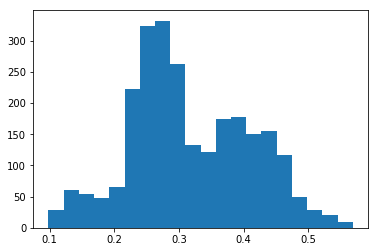

In [32]:
plt.hist(todasAcuraciasKFold, bins=20)

In [34]:
numpy.max(todasAcuraciasKFold)

0.5686274509803921

# TRAIN TEST SPLIT

In [0]:
with open('/content/drive/My Drive/CBIC2019/logTTS.txt', 'w') as file:

  # O DATASET COMECA SO COM A 23 (CLASSIFICACAO)
  dataset = numpy.delete(datasetOriginal, numpy.s_[0:-1], axis=1)

  # ARRAY DE FEATURES QUE FALTAM, 0 E A PASTA E 23 E A CLASSIFICACAO, POR ISSO NAO ENTRAM
  featuresRestantes = numpy.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

  # ISSO AQUI E PRA PEGAR TODAS AS ACURACIAS DE TODAS AS ITERACOES
  todasAcuraciasTTS = []

  # ENQUANTO HOUVEREM FEATURES A SEREM TESTADAS
  while(len(featuresRestantes) != 0):

      file.write("\n\n\nNOVA ITERAÇÃO DO WHILE")
      file.write("\n\nFeatures restantes: " + str(featuresRestantes))

      melhorAcuraciaKNN = 0
      melhorFeatureKNN = 1

      # PARA CADA FEATURE RESTANTE EU A ADICIONO NAS QUE JA ESTAO SENDO UTILIZADAS
      for i, featureAtual in enumerate(featuresRestantes):

          file.write("\n\nTestando a feature " + str(featureAtual))

          # REARRANJO O DATASET COM A FEATURE ATUAL
          dataset = rearranjarDataset(dataset, datasetOriginal, featureAtual, i)

          # AGORA QUE JA TENHO UM DATASET COM AS FEATURES DA VEZ, TENHO QUE TESTAR OS CLASSIFICADORES
          knn = KNeighborsClassifier(7)

          # SEPARANDO O QUE E X E Y PRA MANDAR PRO TTS
          x = numpy.delete(dataset, dataset.shape[1] - 1, axis=1) # exclui a coluna do ultima
          y = numpy.delete(dataset, numpy.s_[0:dataset.shape[1] - 1], axis=1).ravel()
          
          # SEPARANDO COM TTS
          xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, random_state=42, shuffle=True)

          # TREINANDO O CLASSIFICADOR (ignorando a pasta e usando a coluna 23 como target)
          knn = knn.fit(xTrain, yTrain)

          # PREDIZENDO
          yKNN = knn.predict(xTest)

          # VERIFICANDO A ACURACIA
          acuraciaTTS = accuracy_score(yTest, yKNN)

          # VOU COLOCAR NAS ACURACIAS GERAIS
          todasAcuraciasTTS.append(acuraciaTTS)

          file.write("\nA acurácias do TTS foi " + str(acuraciaTTS))
          file.write("\nA melhor acurácia até agora tinha sido " + str(melhorAcuraciaKNN))

          # AGORA JA TENHO A ACURACIA DO TTS, 
          # VOU VER SE COM ESSA FEATURE O RESULTADO FOI BOM
          if acuraciaTTS > melhorAcuraciaKNN:
              file.write("\nNova melhor feature identificada!")
              melhorAcuraciaKNN = acuraciaTTS
              melhorFeatureKNN = featureAtual
              file.write("\nMelhor feature: " + str(melhorFeatureKNN) + ". Melhor acurácia: " + str(acuraciaTTS))

      # DEPOIS QUE ACABAR, EU REMOVO A MELHOR FEATURE DAS FEATURES RESTANTES E COLOCO ELA FIXA NO DATASET
      file.write("\n\nTerminou o while. A melhor feature foi a " + str(melhorFeatureKNN) + ". Colocando-a fixa no dataset.")
      dataset, featuresRestantes = novaMelhorFeature(dataset, datasetOriginal, melhorFeatureKNN, featuresRestantes)

(array([ 8.,  6., 25., 16., 11., 24., 32.,  2., 13.,  4.,  8.,  6., 13.,
         9., 14., 10., 10., 16., 12., 14.]),
 array([0.13284471, 0.16509391, 0.19734311, 0.2295923 , 0.2618415 ,
        0.2940907 , 0.3263399 , 0.3585891 , 0.3908383 , 0.42308749,
        0.45533669, 0.48758589, 0.51983509, 0.55208429, 0.58433349,
        0.61658268, 0.64883188, 0.68108108, 0.71333028, 0.74557948,
        0.77782868]),
 <a list of 20 Patch objects>)

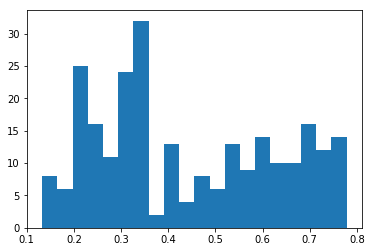

In [83]:
plt.hist(todasAcuraciasTTS, bins=20)

In [84]:
numpy.max(todasAcuraciasTTS)

0.7778286761337608